# Análisis Exploratorio de Datos

En este notebook realizamos el análisis exploratorio del dataset "Wearable Device Dataset from Induced Stress and Structured Exercise Sessions" (Hongn et al., 2025). El dataset contiene señales fisiológicas capturadas mediante el dispositivo Empatica E4 durante tres protocolos experimentales:

1. STRESS: Inducción de estrés agudo mediante tareas cognitivas (TMCT, tareas de opinión, resta consecutiva)
2. AEROBIC: Ejercicio aeróbico en bicicleta estática siguiendo el protocolo Storer-Davis (~35 min)
3. ANAEROBIC: Sprints de máxima intensidad siguiendo el protocolo Wingate (30-45s)

Las señales disponibles son:
- EDA (Electrodermal Activity): 4 Hz - Actividad del sistema nervioso simpático
- BVP (Blood Volume Pulse): 64 Hz - Fotopletismografía para derivar HR y HRV
- HR (Heart Rate): Frecuencia cardíaca derivada de BVP
- IBI (Inter-Beat Interval): Intervalos entre latidos para análisis de HRV
- TEMP (Temperature): 4 Hz - Temperatura periférica de la piel
- ACC (Accelerometer): 32 Hz - Acelerómetro triaxial para detectar movimiento
- tags.csv: Timestamps que marcan cambios de fase en el protocolo

Entonces, el objetivo de este notebook es seguir la siguiente estructura de análisis:
1. Exploración de la estructura del dataset: Organización de carpetas y archivos
2. Carga y visualización de señales: Ejemplos de señales crudas de un sujeto
3. Segmentación por protocolo: Uso de tags para dividir señales en fases
4. Procesamiento multi-sujeto: Extracción de segmentos de TODOS los sujetos
5. Análisis de distribución: Clases, balance, características por condición
6. Preparación para Feature Engineering: Guardado de segmentos procesados

In [61]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("bright")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

BASE_DIR = os.path.abspath("..")
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

from src.utils import load_signal, load_tags, _parse_tag_value, segment_signal_by_tags, get_phase_label

## Exploración de la estructura del dataset
El directorio principal contiene distintos archivos auxiliares (información de sujetos, diccionarios, licencias) y la carpeta principal `Wearable_Dataset`, que contiene los datos fisiológicos organizados por condición experimental:

- STRESS
- AEROBIC
- ANAEROBIC

Dentro de cada una de estas carpetas se encuentran los sujetos, identificados como "Sxx" (sujetos masculinos) o "fxx" (sujetos femeninos).

Para cada sujeto existen los siguientes archivos:

- `EDA.csv` — Actividad electrodermal  
- `BVP.csv` — Fotopletismografía (pulso)  
- `TEMP.csv` — Temperatura periférica  
- `HR.csv` — Heart Rate  
- `IBI.csv` — Intervalos entre latidos  
- `ACC.csv` — Acelerometría (3 ejes)  
- `tags.csv` — Timestamps donde cambia la condición experimental

In [62]:
env_override = os.environ.get("WEARABLE_DATASET_DIR")
default_dir = os.path.join(
    BASE_DIR,
    "data",
    "wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1"
)
DATASET_DIR = env_override if env_override else default_dir

if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError(f"No se encontró el dataset en: {DATASET_DIR}")

print(f"\nContenido del directorio principal:")
for item in sorted(os.listdir(DATASET_DIR)):
    item_path = os.path.join(DATASET_DIR, item)
    print(f" - {item}")


Contenido del directorio principal:
 - Data_Dictionary.csv
 - LICENSE.txt
 - README.txt
 - SHA256SUMS.txt
 - Stress_Level_v1.csv
 - Stress_Level_v2.csv
 - Wearable_Dataset
 - Wearable_Dataset.ipynb
 - data_constraints.txt
 - subject-info.csv


In [63]:
wearable_dir = os.path.join(DATASET_DIR, "Wearable_Dataset")

print("ESTRUCTURA DEL DATASET:")
for condition in ['STRESS', 'AEROBIC', 'ANAEROBIC']:
    condition_dir = os.path.join(wearable_dir, condition)
    
    if not os.path.exists(condition_dir):
        print(f"\n{condition}: No encontrado")
        continue
    
    subjects = [s for s in os.listdir(condition_dir) if os.path.isdir(os.path.join(condition_dir, s))]
    
    print(f"\n{condition}:")
    print(f"   Total de sujetos: {len(subjects)}")
    print(f"   Sujetos v1 (Sxx): {len([s for s in subjects if s.startswith('S')])}")
    print(f"   Sujetos v2 (fxx): {len([s for s in subjects if s.startswith('f')])}")

ESTRUCTURA DEL DATASET:

STRESS:
   Total de sujetos: 37
   Sujetos v1 (Sxx): 18
   Sujetos v2 (fxx): 19

AEROBIC:
   Total de sujetos: 31
   Sujetos v1 (Sxx): 18
   Sujetos v2 (fxx): 13

ANAEROBIC:
   Total de sujetos: 32
   Sujetos v1 (Sxx): 19
   Sujetos v2 (fxx): 13


## Carga y Visualización de Señales

Seleccionamos un sujeto representativo para visualizar las señales crudas y entender su estructura temporal.

Para este ejemplo, cargaremos el sujeto S01 del protocolo STRESS.

In [64]:
EXAMPLE_CONDITION = "STRESS"
EXAMPLE_SUBJECT = "S01"

subject_path = os.path.join(wearable_dir, EXAMPLE_CONDITION, EXAMPLE_SUBJECT)

if not os.path.exists(subject_path):
    raise FileNotFoundError(f"Sujeto {EXAMPLE_SUBJECT} no encontrado en {EXAMPLE_CONDITION}")

In [65]:
signals = {}

eda_path = os.path.join(subject_path, "EDA.csv")
if os.path.exists(eda_path):
    signals['EDA'] = load_signal(eda_path)
    print(f"EDA: {len(signals['EDA']['values'])} muestras @ {signals['EDA']['sampling_rate']} Hz")

bvp_path = os.path.join(subject_path, "BVP.csv")
if os.path.exists(bvp_path):
    signals['BVP'] = load_signal(bvp_path)
    print(f"BVP: {len(signals['BVP']['values'])} muestras @ {signals['BVP']['sampling_rate']} Hz")

temp_path = os.path.join(subject_path, "TEMP.csv")
if os.path.exists(temp_path):
    signals['TEMP'] = load_signal(temp_path)
    print(f"TEMP: {len(signals['TEMP']['values'])} muestras @ {signals['TEMP']['sampling_rate']} Hz")

acc_path = os.path.join(subject_path, "ACC.csv")
if os.path.exists(acc_path):
    signals['ACC'] = load_signal(acc_path)
    print(f"ACC: {len(signals['ACC']['values'])} muestras @ {signals['ACC']['sampling_rate']} Hz")

hr_path = os.path.join(subject_path, "HR.csv")
if os.path.exists(hr_path):
    signals['HR'] = load_signal(hr_path)
    print(f"HR: {len(signals['HR']['values'])} muestras @ {signals['HR']['sampling_rate']} Hz")

ibi_path = os.path.join(subject_path, "IBI.csv")
if os.path.exists(ibi_path):
    try:
        ibi_data = pd.read_csv(ibi_path, header=None, names=['time', 'ibi'])
        signals['IBI'] = ibi_data
        print(f"IBI: {len(ibi_data)} intervalos")
    except Exception as e:
        print(f"IBI: Error al cargar - {e}")

tags_path = os.path.join(subject_path, "tags.csv")
if os.path.exists(tags_path):
    with open(tags_path, 'r') as f:
        tags = [_parse_tag_value(line) for line in f.readlines() if line.strip()]
    signals['tags'] = tags
    print(f"Tags: {len(tags)} marcas temporales")

print(f"\nTotal de señales cargadas: {len(signals)}")

EDA: 8898 muestras @ 4.0 Hz
BVP: 142351 muestras @ 64.0 Hz
TEMP: 8896 muestras @ 4.0 Hz
ACC: 71178 muestras @ 32.0 Hz
HR: 2215 muestras @ 1.0 Hz
IBI: 871 intervalos
Tags: 13 marcas temporales

Total de señales cargadas: 7


## 2.1 Visualización de Señales Crudas

Visualizamos las señales temporales completas para:
1. Identificar artefactos o ruido
2. Observar cambios asociados a las fases del protocolo
3. Validar que las señales sean coherentes

Las líneas verticales rojas indican los tags que marcan cambios de fase.

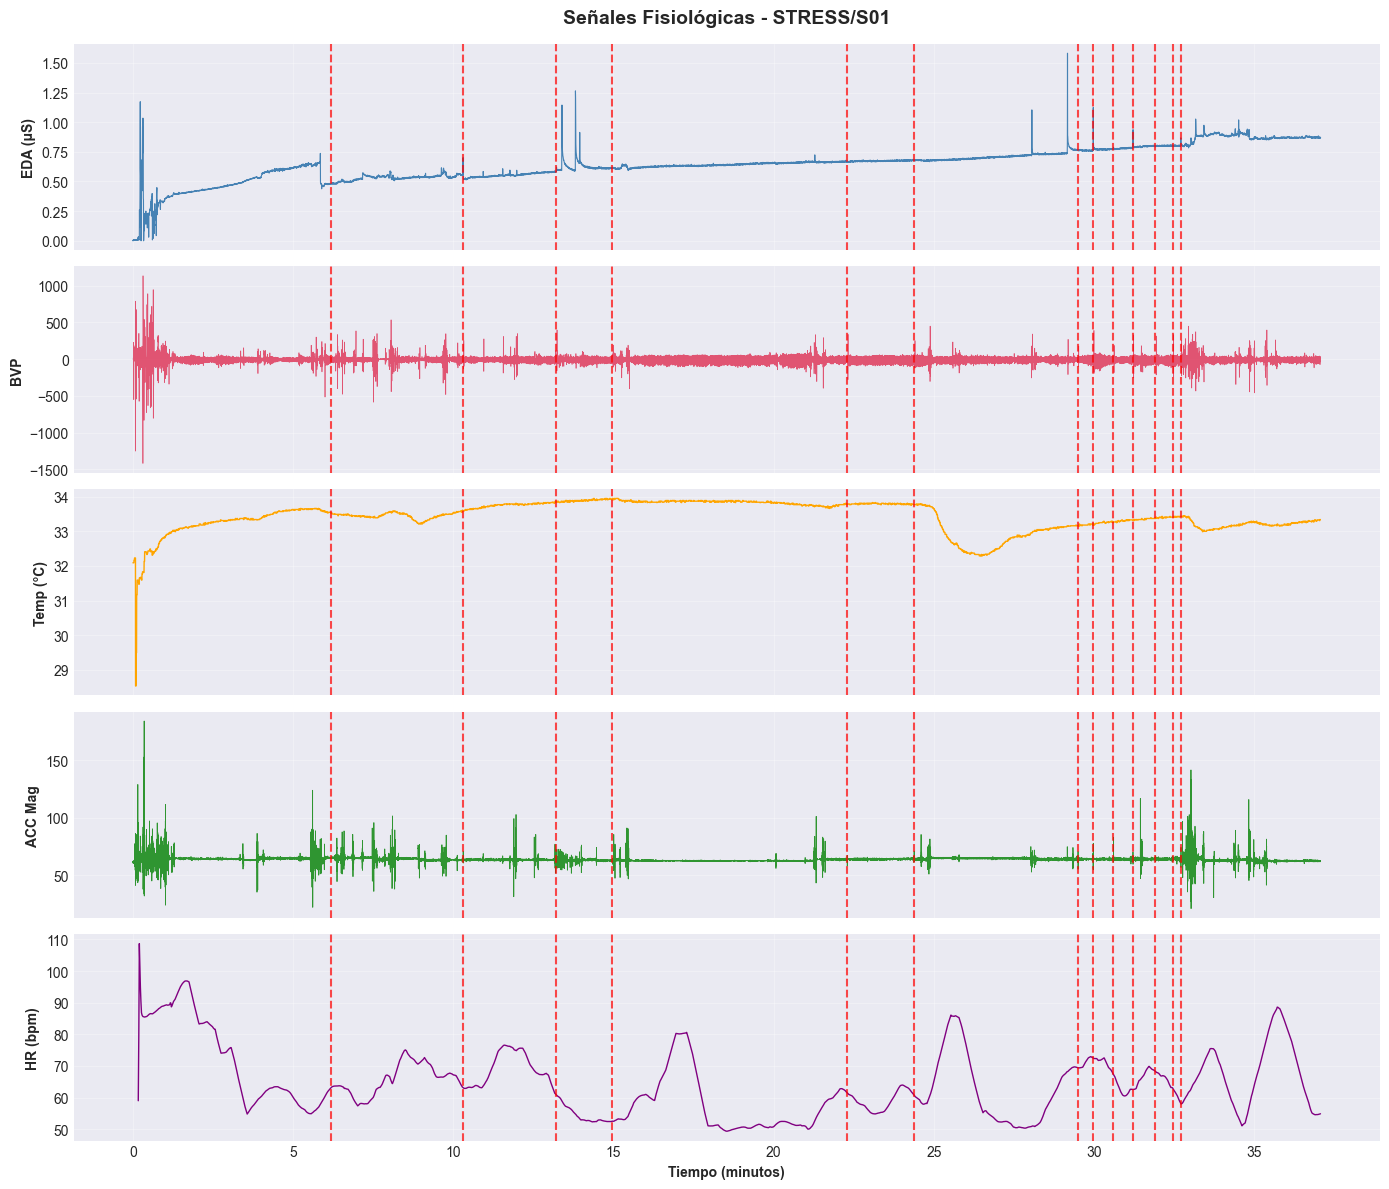

Duración total del experimento: 37.1 minutos (2224 segundos)
Número de tags (fases): 13
Tags (en minutos desde inicio):
      Tag 0: 6.18 min
      Tag 1: 10.30 min
      Tag 2: 13.22 min
      Tag 3: 14.97 min
      Tag 4: 22.30 min
      Tag 5: 24.38 min
      Tag 6: 29.50 min
      Tag 7: 29.97 min
      Tag 8: 30.60 min
      Tag 9: 31.22 min
      Tag 10: 31.92 min
      Tag 11: 32.45 min
      Tag 12: 32.70 min


In [66]:
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

if 'EDA' in signals:
    time_ref = signals['EDA']['start_time']
else:
    time_ref = signals[list(signals.keys())[0]]['start_time']

if 'EDA' in signals:
    time_min = (signals['EDA']['time'] - time_ref) / 60
    axes[0].plot(time_min, signals['EDA']['values'], linewidth=0.8, color='steelblue')
    axes[0].set_ylabel('EDA (μS)', fontweight='bold')
    axes[0].set_title(f'Señales Fisiológicas - {EXAMPLE_CONDITION}/{EXAMPLE_SUBJECT}', 
                      fontsize=14, fontweight='bold', pad=15)
    axes[0].grid(alpha=0.3)

if 'BVP' in signals:
    time_min = (signals['BVP']['time'] - time_ref) / 60
    axes[1].plot(time_min, signals['BVP']['values'], linewidth=0.5, color='crimson', alpha=0.7)
    axes[1].set_ylabel('BVP', fontweight='bold')
    axes[1].grid(alpha=0.3)

if 'TEMP' in signals:
    time_min = (signals['TEMP']['time'] - time_ref) / 60
    axes[2].plot(time_min, signals['TEMP']['values'], linewidth=1, color='orange')
    axes[2].set_ylabel('Temp (°C)', fontweight='bold')
    axes[2].grid(alpha=0.3)

if 'ACC' in signals:
    time_min = (signals['ACC']['time'] - time_ref) / 60
    acc_magnitude = np.sqrt(np.sum(signals['ACC']['values']**2, axis=1))
    axes[3].plot(time_min, acc_magnitude, linewidth=0.6, color='green', alpha=0.8)
    axes[3].set_ylabel('ACC Mag', fontweight='bold')
    axes[3].grid(alpha=0.3)

if 'HR' in signals:
    time_min = (signals['HR']['time'] - time_ref) / 60
    axes[4].plot(time_min, signals['HR']['values'], linewidth=1, color='purple')
    axes[4].set_ylabel('HR (bpm)', fontweight='bold')
    axes[4].set_xlabel('Tiempo (minutos)', fontweight='bold')
    axes[4].grid(alpha=0.3)

if 'tags' in signals:
    for tag in signals['tags']:
        tag_min = (tag - time_ref) / 60
        for ax in axes:
            ax.axvline(tag_min, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.show()

if 'EDA' in signals:
    duration_sec = signals['EDA']['time'][-1] - signals['EDA']['time'][0]
    duration_min = duration_sec / 60
    print(f"Duración total del experimento: {duration_min:.1f} minutos ({duration_sec:.0f} segundos)")
    
if 'tags' in signals:
    print(f"Número de tags (fases): {len(signals['tags'])}")
    print(f"Tags (en minutos desde inicio):")
    for i, tag in enumerate(signals['tags']):
        tag_min = (tag - time_ref) / 60
        print(f"      Tag {i}: {tag_min:.2f} min")

## 3. Segmentación por Protocolo

Los tags en el archivo `tags.csv` marcan los momentos exactos donde cambia la fase experimental. Usando estos timestamps, podemos segmentar las señales en ventanas asociadas a cada estado:

### Protocolo STRESS (v1):
- Tag 0 → Tag 1: Baseline (reposo)
- Tag 1 → Tag 2: Stroop Test (estrés cognitivo)
- Tag 2 → Tag 3: Rest (recuperación)
- Tag 3 → Tag 4: TMCT (matemática con presión temporal)
- Tag 4 → Tag 5: Rest (recuperación)
- Tag 5 → Tag 6: Opinion Task (argumentación forzada)
- Tag 6 → final: Subtract Test (resta consecutiva)

### Protocolo STRESS (v2):
Similar pero sin Stroop Test (protocolo mejorado)

### Estrategia de segmentación:
Dividiremos cada intervalo entre tags en ventanas de 60 segundos para crear muestras individuales.

Ejemplo para visualizacion: segmentar EDA del sujeto S01

In [67]:
if 'EDA' in signals and 'tags' in signals:
    eda_segments = segment_signal_by_tags(
        signal_time=signals['EDA']['time'],
        signal_values=signals['EDA']['values'],
        tags=signals['tags'],
        window_size=60
    )
    
    print(f"EDA segmentado en {len(eda_segments)} ventanas de 60 segundos")
    print(f"\nEjemplos de segmentos:")
    print(f"{'Phase':<8} {'Window':<8} {'Inicio (min)':<15} {'Muestras':<10}")
    print("-" * 50)

    time_ref = signals['EDA']['start_time']
    for seg in eda_segments[:10]:
        start_min = (seg['start_time'] - time_ref) / 60
        print(f"{seg['phase_index']:<8} {seg['window_index']:<8} {start_min:<15.2f} {seg['n_samples']:<10}")
    
    if len(eda_segments) > 10:
        print(f"\ny {len(eda_segments) - 10} segmentos más")

EDA segmentado en 21 ventanas de 60 segundos

Ejemplos de segmentos:
Phase    Window   Inicio (min)    Muestras  
--------------------------------------------------
0        0        6.18            240       
0        1        7.18            240       
0        2        8.18            240       
0        3        9.18            240       
1        0        10.30           240       
1        1        11.30           240       
2        0        13.22           240       
3        0        14.97           240       
3        1        15.97           240       
3        2        16.97           240       

y 11 segmentos más


## 3.1 Visualización de Segmentos por Fase

Visualizamos algunos segmentos de EDA correspondientes a diferentes fases para observar las diferencias fisiológicas.

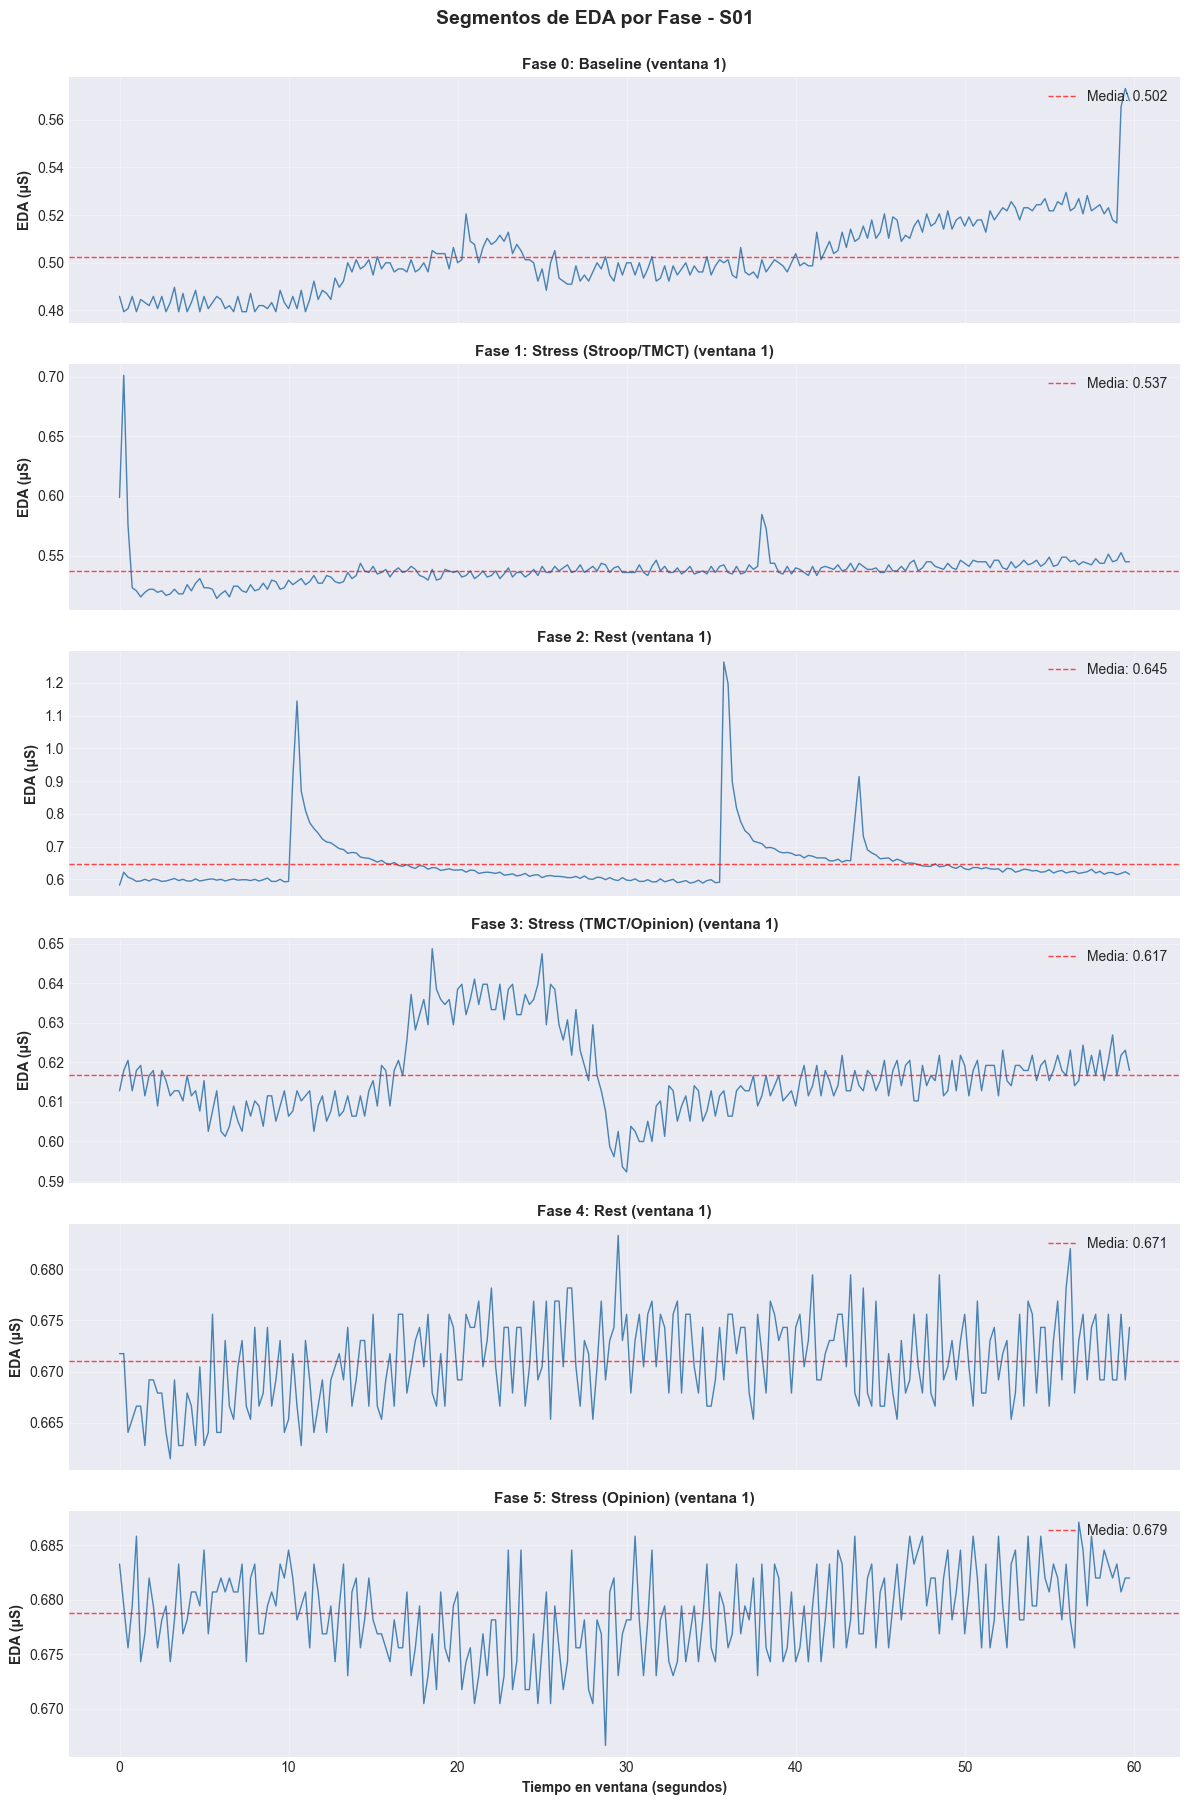

In [68]:
if eda_segments:
    segments_by_phase = {}
    for seg in eda_segments:
        phase = seg['phase_index']
        if phase not in segments_by_phase:
            segments_by_phase[phase] = []
        segments_by_phase[phase].append(seg)
    
    n_phases = len(segments_by_phase)
    fig, axes = plt.subplots(n_phases, 1, figsize=(12, 3*n_phases), sharex=True)
    
    if n_phases == 1:
        axes = [axes]
    
    phase_labels = {
        0: 'Baseline',
        1: 'Stress (Stroop/TMCT)',
        2: 'Rest',
        3: 'Stress (TMCT/Opinion)',
        4: 'Rest',
        5: 'Stress (Opinion)',
        6: 'Stress (Subtract)'
    }
    
    for idx, (phase, segs) in enumerate(sorted(segments_by_phase.items())):
        if segs:
            seg = segs[0]
            
            time_seg = seg['time'] - seg['time'][0]
            
            axes[idx].plot(time_seg, seg['values'], linewidth=1, color='steelblue')
            axes[idx].set_ylabel('EDA (μS)', fontweight='bold')
            axes[idx].set_title(f"Fase {phase}: {phase_labels.get(phase, 'Unknown')} (ventana 1)", 
                               fontsize=11, fontweight='bold')
            axes[idx].grid(alpha=0.3)
            axes[idx].axhline(np.mean(seg['values']), color='red', linestyle='--', 
                            linewidth=1, alpha=0.7, label=f'Media: {np.mean(seg["values"]):.3f}')
            axes[idx].legend(loc='upper right')
    
    axes[-1].set_xlabel('Tiempo en ventana (segundos)', fontweight='bold')
    plt.suptitle(f'Segmentos de EDA por Fase - {EXAMPLE_SUBJECT}', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

## 4. Procesamiento Multi-Sujeto

Hasta ahora hemos trabajado con un solo sujeto de ejemplo. Ahora procesaremos todos los sujetos de las tres condiciones experimentales para construir un dataset completo.

### Estrategia:
1. Iterar sobre STRESS, AEROBIC, ANAEROBIC
2. Para cada sujeto, cargar señales y tags
3. Segmentar en ventanas de 60 segundos
4. Guardar metadatos de cada segmento
5. Acumular en un DataFrame global

Los segmentos se guardarán para que el siguiente notebook (Feature Engineering) pueda procesarlos y extraer features avanzados (FFT, LCT, etc.).

In [69]:
print("PROCESAMIENTO DE TODOS LOS SUJETOS:")

WINDOW_SIZE = 60
CONDITIONS = ['STRESS', 'AEROBIC', 'ANAEROBIC']

all_segments_metadata = []

total_subjects = 0
total_segments = 0
errors = []

for condition in CONDITIONS:
    condition_dir = os.path.join(wearable_dir, condition)
    subjects = [s for s in os.listdir(condition_dir) 
                if os.path.isdir(os.path.join(condition_dir, s))]
    
    for subject_id in sorted(subjects):
        subject_path = os.path.join(condition_dir, subject_id)
                
        try:
            eda_path = os.path.join(subject_path, "EDA.csv")
            if not os.path.exists(eda_path):
                raise FileNotFoundError("EDA.csv no encontrado")
            
            eda_signal = load_signal(eda_path)
            
            tags_path = os.path.join(subject_path, "tags.csv")
            if not os.path.exists(tags_path):
                raise FileNotFoundError("tags.csv no encontrado")
            
            tags = load_tags(tags_path)
            tags = [t for t in tags if t is not None]
            
            if len(tags) < 2:
                raise ValueError("Menos de 2 tags - no se puede segmentar")
            
            segments = segment_signal_by_tags(
                signal_time=eda_signal['time'],
                signal_values=eda_signal['values'],
                tags=tags,
                window_size=WINDOW_SIZE
            )
            
            if len(segments) == 0:
                raise ValueError("No se generaron segmentos")
            
            for seg in segments:
                label = get_phase_label(condition, seg['phase_index'], subject_id)
                
                all_segments_metadata.append({
                    'subject_id': subject_id,
                    'condition': condition,
                    'phase_index': seg['phase_index'],
                    'window_index': seg['window_index'],
                    'start_time': seg['start_time'],
                    'end_time': seg['end_time'],
                    'duration': WINDOW_SIZE,
                    'n_samples_eda': seg['n_samples'],
                    'label': label
                })
            
            total_subjects += 1
            total_segments += len(segments)
            
        except Exception as e:
            errors.append({
                'subject_id': subject_id,
                'condition': condition,
                'error': str(e)
            })

print(f"Sujetos procesados: {total_subjects}")
print(f"Total de ventanas: {total_segments}")
print(f"Errores: {len(errors)}")

if errors:
    print(f"\nSujetos con errores:")
    for err in errors[:10]:
        print(f"  - {err['condition']}/{err['subject_id']}: {err['error']}")

PROCESAMIENTO DE TODOS LOS SUJETOS:
Sujetos procesados: 98
Total de ventanas: 1976
Errores: 2

Sujetos con errores:
  - STRESS/f14_a: Menos de 2 tags - no se puede segmentar
  - AEROBIC/S11_b: Menos de 2 tags - no se puede segmentar
Sujetos procesados: 98
Total de ventanas: 1976
Errores: 2

Sujetos con errores:
  - STRESS/f14_a: Menos de 2 tags - no se puede segmentar
  - AEROBIC/S11_b: Menos de 2 tags - no se puede segmentar


In [70]:
df_segments = pd.DataFrame(all_segments_metadata)

print("DATASET DE SEGMENTOS:")
print(f"Shape: {df_segments.shape}")

df_segments.head(10)

DATASET DE SEGMENTOS:
Shape: (1976, 9)


,subject_id,condition,phase_index,window_index,start_time,end_time,duration,n_samples_eda,label
0,S01,STRESS,0,0,1.361394e+09,1.361394e+09,60,240,rest
1,S01,STRESS,0,1,1.361394e+09,1.361394e+09,60,240,rest
2,S01,STRESS,0,2,1.361394e+09,1.361394e+09,60,240,rest
3,S01,STRESS,0,3,1.361394e+09,1.361394e+09,60,240,rest
4,S01,STRESS,1,0,1.361394e+09,1.361394e+09,60,240,stress
5,S01,STRESS,1,1,1.361394e+09,1.361394e+09,60,240,stress
6,S01,STRESS,2,0,1.361395e+09,1.361395e+09,60,240,rest
7,S01,STRESS,3,0,1.361395e+09,1.361395e+09,60,240,stress
8,S01,STRESS,3,1,1.361395e+09,1.361395e+09,60,240,stress
9,S01,STRESS,3,2,1.361395e+09,1.361395e+09,60,240,stress


## 5. Análisis de Distribución de Datos

Ahora que tenemos todos los segmentos procesados, analizamos:
1. Distribución de clases (balanceo)
2. Distribución por condición experimental
3. Distribución por sujeto
4. Identificar posibles problemas (desbalance, sujetos con pocos datos, etc.)

DISTRIBUCIÓN DE CLASES:
label
rest         634
aerobic      611
stress       267
anaerobic    236
unknown      228
Name: count, dtype: int64

Total de segmentos: 1976


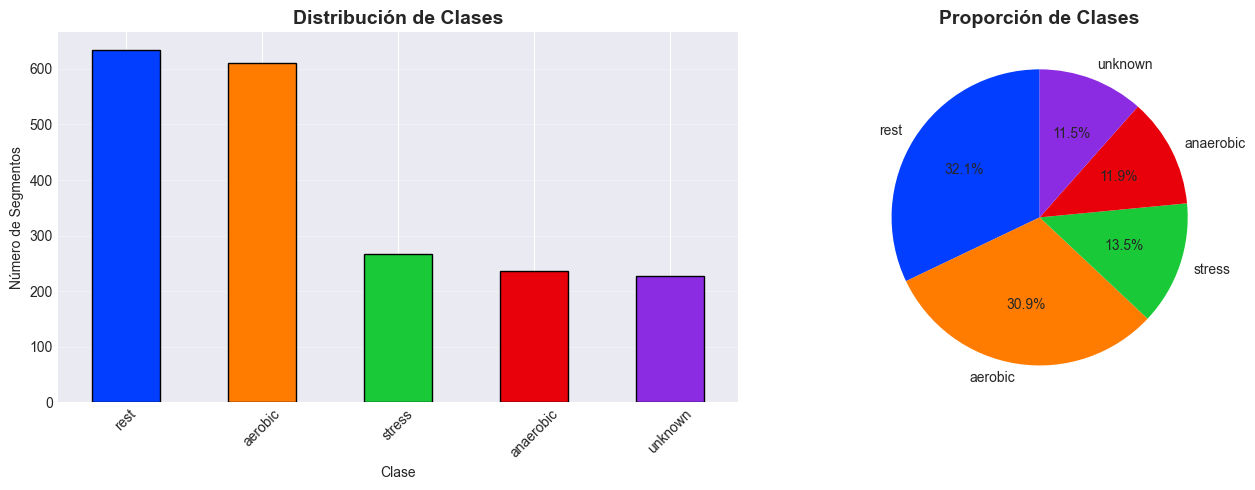


Ratio de desbalance (max/min): 2.78x
Dataset desbalanceado


In [79]:
print("DISTRIBUCIÓN DE CLASES:")

class_counts = df_segments['label'].value_counts()
print(class_counts)
print(f"\nTotal de segmentos: {len(df_segments)}")

palette = sns.color_palette("bright", len(class_counts))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts.plot(kind='bar', ax=axes[0], color=palette, edgecolor='black')
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Número de Segmentos')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

class_counts.plot(kind='pie', ax=axes[1], colors=palette, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de desbalance (max/min): {imbalance_ratio:.2f}x")

if imbalance_ratio > 2:
    print("Dataset desbalanceado")
else:
    print("Dataset balanceado")


DISTRIBUCIÓN POR CONDICIÓN EXPERIMENTAL:
label      aerobic  anaerobic  rest  stress  unknown   All
condition                                                 
AEROBIC        611          0    63       0        0   674
ANAEROBIC        0        236   194       0        0   430
STRESS           0          0   377     267      228   872
All            611        236   634     267      228  1976


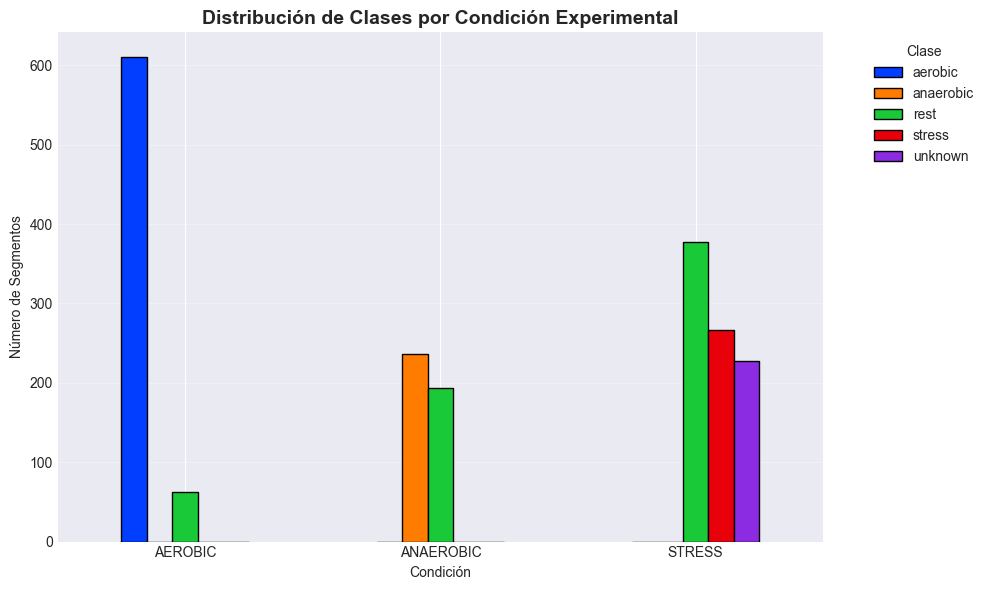

In [72]:
print("\nDISTRIBUCIÓN POR CONDICIÓN EXPERIMENTAL:")

ct = pd.crosstab(df_segments['condition'], df_segments['label'], margins=True)
print(ct)

fig, ax = plt.subplots(figsize=(10, 6))
ct_plot = pd.crosstab(df_segments['condition'], df_segments['label'])
ct_plot.plot(kind='bar', stacked=False, ax=ax, edgecolor='black')
ax.set_title('Distribución de Clases por Condición Experimental', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condición')
ax.set_ylabel('Número de Segmentos')
ax.legend(title='Clase', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


DISTRIBUCIÓN POR SUJETO:
Total de sujetos: 39
Media de segmentos por sujeto: 50.7
Mediana: 52.0
Min-Max: 3 - 83


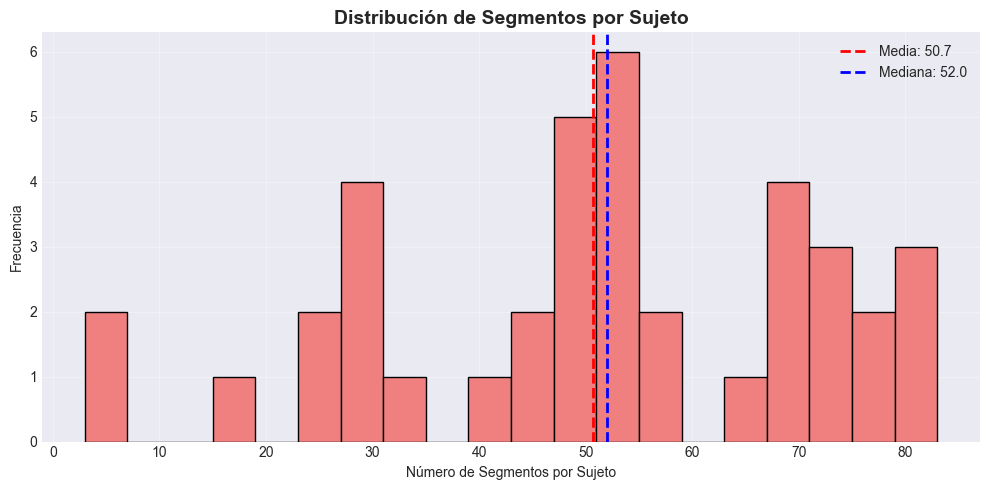

In [73]:
print("\nDISTRIBUCIÓN POR SUJETO:")

subject_counts = df_segments['subject_id'].value_counts()
print(f"Total de sujetos: {len(subject_counts)}")
print(f"Media de segmentos por sujeto: {subject_counts.mean():.1f}")
print(f"Mediana: {subject_counts.median():.1f}")
print(f"Min-Max: {subject_counts.min()} - {subject_counts.max()}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(subject_counts.values, bins=20, edgecolor='black', color='lightcoral')
ax.set_xlabel('Número de Segmentos por Sujeto')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Segmentos por Sujeto', fontsize=14, fontweight='bold')
ax.axvline(subject_counts.mean(), color='red', linestyle='--', linewidth=2, 
          label=f'Media: {subject_counts.mean():.1f}')
ax.axvline(subject_counts.median(), color='blue', linestyle='--', linewidth=2,
          label=f'Mediana: {subject_counts.median():.1f}')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5.1 Análisis de Calidad de Datos

Verificamos posibles problemas de calidad consultando el archivo `data_constraints.txt` provisto por los autores.

In [74]:
constraints_path = os.path.join(DATASET_DIR, "data_constraints.txt")

if os.path.exists(constraints_path):
    print("RESTRICCIONES Y PROBLEMAS CONOCIDOS:")
    
    try:
        with open(constraints_path, 'r', encoding='utf-8') as f:
            print(f.read())
    except UnicodeDecodeError:
        with open(constraints_path, 'r', encoding='latin-1') as f:
            print(f.read())
else:
    print("Archivo data_constraints.txt no encontrado")

RESTRICCIONES Y PROBLEMAS CONOCIDOS:
STRESS
	S02: Files downloaded from E4 Connect have duplicated signals. Duplicated raw values start in: ACC.csv: row 49,545; BVP.csv: row 99,091; EDA.csv and TEMP.csv: row 6,195. As IBI and HR files are obtained from the BVP signal through Empatica's algorithm, it is not evident where the duplicated data start.
	f07: The protection dock was never removed from the wristband, covering the PPG and TEMPERATURE sensors. Thus, only the ELECTRODERMAL ACTIVITY AND ACCELEROMETER DATA measurements are valid.
	f14: Bluetooth connection was lost during registration. The baseline is in file f14_a, and the rest of the protocol is in file f14_b.

AEROBIC
	S03: Ended the protocol early, only reaching 90 rpm.
	S07: Ended the protocol early, only reaching 95 rpm.
	S11: Bluetooth connection was lost during registration. File S11_a includes data up to 105 rpm, and S11_b includes the last 110 rpm block.
	S12: Did not perform the aerobic protocol, so there are no d

In [75]:
problematic_subjects = {
    'STRESS': ['S02', 'f07', 'f14_a', 'f14_b'],
    'AEROBIC': ['S03', 'S07', 'S11', 'S12'],
    'ANAEROBIC': ['S06', 'S16']
}

print("\nSUJETOS PROBLEMÁTICOS EN EL DATASET:")

for condition, subjects in problematic_subjects.items():
    print(f"\n{condition}:")
    for subj in subjects:
        count = len(df_segments[(df_segments['condition'] == condition) & 
                                (df_segments['subject_id'] == subj)])
        status = "Procesado" if count > 0 else "No procesado"
        print(f"  {subj}: {count} segmentos - {status}")


SUJETOS PROBLEMÁTICOS EN EL DATASET:

STRESS:
  S02: 16 segmentos - Procesado
  f07: 33 segmentos - Procesado
  f14_a: 0 segmentos - No procesado
  f14_b: 26 segmentos - Procesado

AEROBIC:
  S03: 17 segmentos - Procesado
  S07: 19 segmentos - Procesado
  S11: 0 segmentos - No procesado
  S12: 0 segmentos - No procesado

ANAEROBIC:
  S06: 7 segmentos - Procesado
  S16: 0 segmentos - No procesado
  S06: 7 segmentos - Procesado
  S16: 0 segmentos - No procesado


## 6. Guardar Dataset de Segmentos

Guardamos el DataFrame de segmentos procesados para que el siguiente notebook (**Feature Engineering**) pueda:
1. Cargar los segmentos de cada sujeto
2. Extraer features avanzados (FFT, LCT, convolución, etc.)
3. Construir el dataset final para Machine Learning

In [76]:
output_dir = os.path.join(BASE_DIR, "data")
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "segments_metadata.csv")

df_segments.to_csv(output_file, index=False)

print(f"Metadata de segmentos guardado en: {output_file}")
print(f"   Shape: {df_segments.shape}")
print(f"   Columnas: {list(df_segments.columns)}")

Metadata de segmentos guardado en: /Users/sofiaramos/Desktop/ML/TPF/data/segments_metadata.csv
   Shape: (1976, 9)
   Columnas: ['subject_id', 'condition', 'phase_index', 'window_index', 'start_time', 'end_time', 'duration', 'n_samples_eda', 'label']
